In [2]:
import datetime
import yfinance as yf
import statsmodels.tsa.stattools as sm
import seaborn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/home/mmelnik1/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/mmelnik1/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/mmelnik1/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection i

In [107]:
stock = 'aapl'
train_start = '2020-01-01'
train_end = '2020-10-31'
sim_end = pd.Timestamp('2020-12-31', tz='America/New_York')
scen_size = 10000

In [28]:
ticker = yf.Ticker('aapl')

In [42]:
train_set = ticker.history(start=train_start, end=train_end)['Close']

In [30]:
s0 = train_set.iloc[-1]
dt = 1

In [43]:
train_set

Date
2020-01-02 00:00:00-05:00     72.960472
2020-01-03 00:00:00-05:00     72.251152
2020-01-06 00:00:00-05:00     72.826866
2020-01-07 00:00:00-05:00     72.484344
2020-01-08 00:00:00-05:00     73.650360
                                ...    
2020-10-26 00:00:00-04:00    112.562172
2020-10-27 00:00:00-04:00    114.078636
2020-10-28 00:00:00-04:00    108.795418
2020-10-29 00:00:00-04:00    112.826317
2020-10-30 00:00:00-04:00    106.506020
Name: Close, Length: 211, dtype: float64

In [44]:
n_of_wkdays = pd.date_range(start=pd.to_datetime(train_end,
                                                 format="%Y-%m-%d") + pd.Timedelta('1 days'),
                            end=pd.to_datetime(sim_end,
                                               format="%Y-%m-%d")).to_series().map(lambda x: 1 if x.isoweekday() in range(1, 6) else 0).sum()
T = n_of_wkdays

In [47]:
N = T / dt
t = np.arange(1, N + 1)

In [52]:
daily_returns = ((train_set / train_set.shift(1)) - 1)[1:]
mu = daily_returns.mean()

In [54]:
sigma = np.std(daily_returns)

In [62]:
b = {str(scen): np.random.normal(0,1, int(N)) for scen in range(1, scen_size + 1)}

In [73]:
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

In [78]:
drift = (mu - 0.5 * sigma ** 2) * t
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}

In [93]:
S = np.array([s0 * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)])
S = np.hstack((np.array([[s0] for scen in range(1, scen_size + 1)]), S))

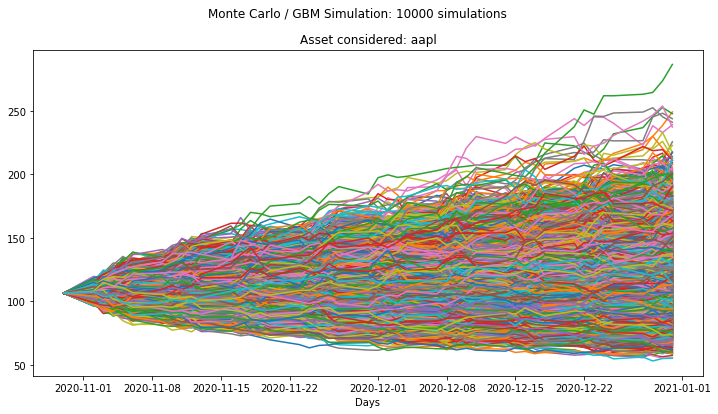

In [111]:
#fig, ax = plt.subplots()
plt.figure(figsize=(12,6))
plt.suptitle('Monte Carlo / GBM Simulation: ' +  str(scen_size) + ' simulations')
plt.title('Asset considered: ' + stock)
plt.xlabel('Days')


for i in range(scen_size):
    plt.plot(pd.date_range(start=train_set.index[-1],
                           end=sim_end,
                           freq='D').map(lambda x: x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S[i, :])

plt.show()